<a href="https://colab.research.google.com/github/yj336/Yelp-sentiment-anaylsis/blob/master/Yelp_05_Gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1YLqx8zMU6EXdHdIyYiY8Usdakc7o-0SE'}) # replace the id with id of file you want to access https://drive.google.com/open?id=1aehitOH9t2vkDlDxTY3qhZUuX3Mf7_6b
downloaded.GetContentFile('review_LV_5_years.csv')  

In [0]:
import pandas as pd

In [0]:
df_review = pd.read_csv('review_LV_5_years.csv')[['text','stars']]

In [0]:
df_review.head()

,text,stars
0,The food is always good and the prices are rea...,4.0
1,My wife ate here and I had pizza from another ...,5.0
2,Greenberg's Deli is part of the food court are...,4.0
3,I was a bit skeptical at first since it seems ...,4.0
4,Authentic New York Style Deli. This is in the...,5.0


In [0]:
comments = df_review.text.apply(lambda x: x.lower().split())

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
with open('stopwords.txt', 'w') as filehandle:
    for listitem in stop:
        filehandle.write('%s\n' % listitem)

In [0]:
import re
# Remove stop words
clean_comments = []
for comment in comments:
  clean_comment = []
  
  for word in comment:
    word = re.sub(r'[^a-zA-Z]', '', word)
    word = word.lower()
    if word not in stop:
      clean_comment.append(word)
  clean_comments.append(clean_comment)

In [0]:
from gensim.corpora import  WikiCorpus
from gensim.models import Word2Vec
import gensim.downloader as api

In [0]:
# Initialize embeddings

MAX_NB_WORDS = 3000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 25

In [0]:
X = clean_comments
df_review['sentiment'] = df_review['stars'].apply(lambda x: 1 if x == 5 else 0)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, df_review['sentiment'], test_size = 0.2)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 257339 unique tokens.


In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# gensim pre-trained model
from gensim.corpora import  WikiCorpus
from gensim.models import Word2Vec
import gensim.downloader as api
model_glove_twitter = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from keras.utils import to_categorical
import numpy as np
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)


y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))


In [0]:
embeddings_index = {}
for word in model_glove_twitter.vocab:
  embeddings_index[word] = model_glove_twitter[word]

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
del df_review
del clean_comments

https://github.com/ultimate010/crnn/blob/master/sst2_cnn_rnn_kera1.py
### CNN+RNN


In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Concatenate
from keras.regularizers import l2
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.constraints import maxnorm
from keras.datasets import imdb
from keras import callbacks
from keras.utils import generic_utils
from keras.models import Model
from keras.optimizers import Adadelta
import time

batch_size = 50
nb_filter = 200
filter_length = 4
hidden_dims = nb_filter * 2
nb_epoch = 20
RNN = GRU
rnn_output_size = 100
folds = 10

print('Loading data...')


max_features = len(word_index)+1
embedding_dims = EMBEDDING_DIM

print('Train...')
accs = []
first_run = True
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
rand_idx = np.random.permutation(range(len(X_train)))
X_train = X_train[rand_idx]
y_train = y_train[rand_idx]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)


def build_model():
    main_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='main_input')
    embedding  = Embedding(max_features, embedding_dims,
                  weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                  name='embedding')(main_input)

    embedding = Dropout(0.50)(embedding)

    conv4 = Convolution1D(nb_filter=nb_filter,
                          filter_length=4,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv4')(embedding)
    maxConv4 = MaxPooling1D(pool_length=2,
                             name='maxConv4')(conv4)

    conv5 = Convolution1D(nb_filter=nb_filter,
                          filter_length=5,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv5')(embedding)
    maxConv5 = MaxPooling1D(pool_length=2,
                            name='maxConv5')(conv5)

    #x = merge([maxConv4, maxConv5], mode='concat')
    x = Concatenate()([maxConv4, maxConv5])

    x = Dropout(0.15)(x)

    x = RNN(rnn_output_size)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(0.10)(x)

    output = Dense(2, init='he_normal',
                   activation='sigmoid', name='output')(x)

    model = Model(input=main_input, output=output)
    print('model=Model()')
    print(model.summary())
    model.compile(loss={'output':'binary_crossentropy'},
                optimizer=Adadelta(lr=0.95, epsilon=1e-06),
                metrics=["accuracy"])
    return model
model = build_model()
if first_run:
    first_run = False
    print(model.summary())

best_val_acc = 0
best_test_acc = 0



Loading data...
Train...
630646 train sequences
157662 test sequences
X_train shape: (630646, 100)
X_test shape: (157662, 100)










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="conv4", filters=200, kernel_size=4, strides=1, padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(name="maxConv4", pool_size=2)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="conv5", filters=200, kernel_size=5, strides=1, padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(name="maxConv5", pool_size=2)`



model=Model()
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 25)      6433500     main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 25)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv4 (Conv1D)                  (None, 97, 200)      20200       dropout_1[0][0]                  
_____________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="sigmoid", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ma..., outputs=Tensor("ou...)`


In [0]:
nb_epoch = 10
for j in range(nb_epoch):
    a = time.time()
    his = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    validation_data=[X_valid, y_valid],
                    shuffle=True,
                    nb_epoch=1, verbose=1)
    print('Epoch %d/%d\t%s' % (j + 1, nb_epoch, str(his.history)))
    if his.history['val_acc'][0] >= best_val_acc:
        score, acc = model.evaluate(X_test, y_test,
                                    batch_size=batch_size,
                                    verbose=2)
        best_val_acc = his.history['val_acc'][0]
        best_test_acc = acc
        print('Got best epoch  best val acc is %f test acc is %f' %
              (best_val_acc, best_test_acc))
        if len(accs) > 0:
            print('Current avg test acc:', str(np.mean(accs)))
    b = time.time()
    cost = b - a
    left = (nb_epoch - j - 1)
    print('One round cost %ds, %d round %ds %dmin left' % (cost, left,
                                                           cost * left,
                                                           cost * left / 60.0))
accs.append(best_test_acc)
print('Avg test acc:', str(np.mean(accs)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  




Train on 567581 samples, validate on 63065 samples
Epoch 1/1
313000/567581 [===============>..............] - ETA: 8:31 - loss: 0.4633 - acc: 0.7799

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  




Train on 567581 samples, validate on 63065 samples
Epoch 1/1
567581/567581 [==============================] - 1177s 2ms/step - loss: 0.4388 - acc: 0.7946 - val_loss: 0.3785 - val_acc: 0.8264
Epoch 1/10	{'val_loss': [0.37854269340907254], 'val_acc': [0.8264488971914807], 'loss': [0.4387939755377922], 'acc': [0.7945509068288324]}
Epoch 1/10	{'val_loss': [0.37854269340907254], 'val_acc': [0.8264488971914807], 'loss': [0.4387939755377922], 'acc': [0.7945509068288324]}
Got best epoch  best val acc is 0.826449 test acc is 0.830000
One round cost 1289s, 9 round 11607s 193min left
Train on 567581 samples, validate on 63065 samples
Epoch 1/1
    50/567581 [..............................] - ETA: 21:51 - loss: 0.5022 - acc: 0.7600Got best epoch  best val acc is 0.826449 test acc is 0.830000
One round cost 1289s, 9 round 11607s 193min left
Train on 567581 samples, validate on 63065 samples
Epoch 1/1
    50/567581 [..............................] - ETA: 21:51 - loss: 0.5022 - acc: 0.7600

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


567581/567581 [==============================] - 1159s 2ms/step - loss: 0.3951 - acc: 0.8202 - val_loss: 0.3993 - val_acc: 0.8159
Epoch 2/10	{'val_loss': [0.3993289151147668], 'val_acc': [0.8159042208179421], 'loss': [0.3951333010307015], 'acc': [0.8202459163388666]}
One round cost 1159s, 8 round 9274s 154min left
Train on 567581 samples, validate on 63065 samples
Epoch 1/1
    50/567581 [..............................] - ETA: 22:19 - loss: 0.4562 - acc: 0.7600Epoch 2/10	{'val_loss': [0.3993289151147668], 'val_acc': [0.8159042208179421], 'loss': [0.3951333010307015], 'acc': [0.8202459163388666]}
One round cost 1159s, 8 round 9274s 154min left
Train on 567581 samples, validate on 63065 samples
Epoch 1/1
567581/567581 [==============================] - 1162s 2ms/step - loss: 0.3856 - acc: 0.8257 - val_loss: 0.3636 - val_acc: 0.8333
Epoch 3/10	{'val_loss': [0.363646300870346], 'val_acc': [0.8333386135812056], 'loss': [0.38563433320586143], 'acc': [0.8256962389586504]}
Epoch 3/10	{'val_los

In [0]:
best_test_acc

0.8352075901155012

In [0]:
accs

[0.8352075901155012]

In [0]:
y_test_pred = model.predict(X_test)

In [0]:
y_train_pred= model.predict(X_train)

In [0]:
y_test_pred[0],y_test[0]


(array([0.19058391, 0.8094147 ], dtype=float32),
 array([1., 0.], dtype=float32))

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

from keras import metrics
#from keras.metrics import accuracy
#keras.metrics.accuracy(y_true, y_pred)
#print('AUC for training dataset: %.4f'%auroc(y_train, y_train_pred))
print('AUC for testing dataset %.4f'%roc_auc_score(y_test, y_test_pred))
#print('Accuracy for training dataset: %.4f'%accuracy(y_train, y_train_pred))
print('Accuracy for testing dataset: %.4f'%best_test_acc)

AUC for testing dataset 0.9168
Accuracy for testing dataset: 0.8352


In [0]:
from sklearn.metrics import classification_report
y_test_true_report = [x[0] for x in y_test]
y_test_pred_report = [1 if x[0] > x[1] else 0 for x in y_test_pred ]
print(classification_report(y_test_true_report, y_test_pred_report))

              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84     75067
         1.0       0.89      0.78      0.83     82595

    accuracy                           0.83    157662
   macro avg       0.84      0.84      0.83    157662
weighted avg       0.84      0.83      0.83    157662



In [0]:
# Decrease threashold of negative 
y_test_true_report = [x[0] for x in y_test]
y_test_pred_report = [1 if x[0] > 0.45 else 0 for x in y_test_pred ]
print(classification_report(y_test_true_report, y_test_pred_report))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83     75067
         1.0       0.86      0.82      0.84     82595

    accuracy                           0.84    157662
   macro avg       0.84      0.84      0.84    157662
weighted avg       0.84      0.84      0.84    157662



In [0]:
y_pred_keras

array([0.19058391, 0.8094147 , 0.5041953 , ..., 0.18219647, 0.60812926,
       0.3918559 ], dtype=float32)

In [0]:
y_pred_keras.shape, y_test.ravel().shape

((315324,), (315324,))

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = y_test_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [0]:
fpr_keras, tpr_keras, thresholds_keras

(array([0.        , 0.        , 0.        , ..., 0.99898517, 0.99899786,
        1.        ]),
 array([0.00000000e+00, 6.34268245e-06, 2.21993886e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.9999582e+00, 9.9995816e-01, 9.9979246e-01, ..., 4.1976571e-04,
        4.1872263e-04, 4.3332577e-05], dtype=float32))

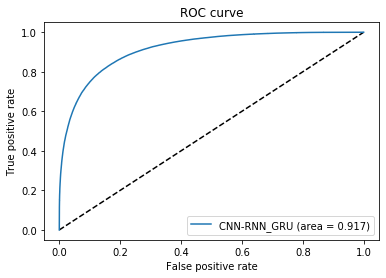

In [0]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN-RNN_GRU (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [0]:
test_1 = 'I hate this place'
test_1_sequences = tokenizer.texts_to_sequences(test_1)
model.predict(test_1)

AttributeError: ignored

In [0]:
model.save("model_CNN_RNN_GRU.h5")
print("Saved model to disk")

Saved model to disk
